In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

## Conditional Variational AutoEncoder (CVAE)

In [2]:
batch_size = 256
latent_dim = 8
epochs = 1000
lr = 1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 10

In [3]:
transform = transforms.ToTensor();
train_loader = DataLoader(
    datasets.MNIST(root="./data", train=True, download=True, transform=transform),
    batch_size=batch_size, shuffle=True
)

### CVAE Model
**layers:**
1. Fully Connected: concat of input images and their labels -> first layer neurons
2. 2 x Fully Connected: first layer nerons -> latent layer neurons (One for mean and one for log of variance)
3. Fullu Connected: concat of latent and labels -> third layer neurons
4. Fully Connected: third layer neurons -> input dimension (a new image)

In [4]:
class CVAE(nn.Module):
    def __init__(self, input_dim=784, label_dim=10, latent_dim=8):
        super().__init__()
        
        self.fc1 = nn.Linear(input_dim + label_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)
        self.fc3 = nn.Linear(latent_dim + label_dim, 256)
        self.fc4 = nn.Linear(256, 512)
        self.fc5 = nn.Linear(512, input_dim)

    def encode(self, x, y):
        h = torch.cat([x, y], dim=1)
        h = F.relu(self.fc1(h))
        h = F.relu(self.fc2(h))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, y):
        h = torch.cat([z, y], dim=1)
        h = F.relu(self.fc3(h))
        h = F.relu(self.fc4(h))
        return torch.sigmoid(self.fc5(h))

    def forward(self, x, y):
        mu, logvar = self.encode(x, y)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z, y)
        return recon_x, mu, logvar

In [5]:
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction="sum")
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

### Training

In [6]:
model = CVAE(latent_dim=latent_dim, label_dim=num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [7]:
save_dir = "checkpoints"
os.makedirs(save_dir, exist_ok=True)

best_loss = float('inf')

for epoch in range(1, epochs + 1):
    model.train()
    train_loss = 0

    for x, labels in train_loader:
        x = x.view(-1, 784).to(device)
        y = F.one_hot(labels, num_classes).float().to(device)

        optimizer.zero_grad()
        recon_x, mu, logvar = model(x, y)
        loss = loss_function(recon_x, x, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    avg_loss = train_loss / len(train_loader.dataset)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {avg_loss:.4f}")

    if epoch % 10 == 0 or avg_loss < best_loss:
        ckpt_path = os.path.join(save_dir, f"epoch_{epoch:03d}.pt")
        torch.save(
            {
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "loss": avg_loss,
            },
            ckpt_path,
        )

        if avg_loss < best_loss:
            best_loss = avg_loss
            best_path = os.path.join(save_dir, "best_model.pt")
            torch.save(
                {
                    "epoch": epoch,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "loss": avg_loss,
                },
                best_path,
            )


Epoch 10, Loss: 129.3822
Epoch 20, Loss: 116.8307
Epoch 30, Loss: 111.6438
Epoch 40, Loss: 108.6807
Epoch 50, Loss: 106.6493
Epoch 60, Loss: 105.1693
Epoch 70, Loss: 103.9431
Epoch 80, Loss: 102.9618
Epoch 90, Loss: 102.0959
Epoch 100, Loss: 101.3450
Epoch 110, Loss: 100.7118
Epoch 120, Loss: 100.1323
Epoch 130, Loss: 99.6358
Epoch 140, Loss: 99.2144
Epoch 150, Loss: 98.7802
Epoch 160, Loss: 98.3847
Epoch 170, Loss: 98.0433
Epoch 180, Loss: 97.7408
Epoch 190, Loss: 97.4243
Epoch 200, Loss: 97.1803
Epoch 210, Loss: 96.9071
Epoch 220, Loss: 96.6893
Epoch 230, Loss: 96.4657
Epoch 240, Loss: 96.2473
Epoch 250, Loss: 96.0607
Epoch 260, Loss: 95.9063
Epoch 270, Loss: 95.7311
Epoch 280, Loss: 95.5452
Epoch 290, Loss: 95.4076
Epoch 300, Loss: 95.2069
Epoch 310, Loss: 95.1092
Epoch 320, Loss: 94.9909
Epoch 330, Loss: 94.8382
Epoch 340, Loss: 94.7207
Epoch 350, Loss: 94.6061
Epoch 360, Loss: 94.4700
Epoch 370, Loss: 94.3684
Epoch 380, Loss: 94.2671
Epoch 390, Loss: 94.1545
Epoch 400, Loss: 94.06

In [7]:
ckpt = torch.load("checkpoints/best_model.pt", map_location=device)
model.load_state_dict(ckpt["model_state_dict"])
optimizer.load_state_dict(ckpt["optimizer_state_dict"])
start_epoch = ckpt["epoch"] + 1
print(f"✅ Loaded checkpoint from epoch {ckpt['epoch']} with loss {ckpt['loss']:.4f}")

✅ Loaded checkpoint from epoch 1000 with loss 91.1003


/tmp/ipykernel_4895/2286329311.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("checkpoints/best_model.pt", map_location=device)


### Visualization

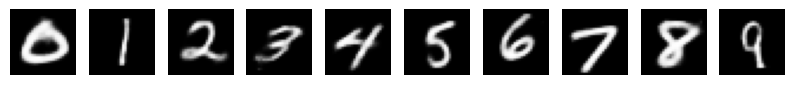

In [11]:
model.eval()
with torch.no_grad():
    z = torch.randn(num_classes, latent_dim).to(device)
    labels = torch.arange(num_classes).to(device)
    y = F.one_hot(labels, num_classes).float()
    # y = F.one_hot(torch.full((10,), 4, device=labels.device), num_classes).float()
    samples = model.decode(z, y.to(device)).cpu().view(-1, 1, 28, 28)

    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(1, num_classes, figsize=(10, 2))
    for i, ax in enumerate(axes):
        ax.imshow(samples[i, 0], cmap="gray")
        ax.axis("off")
    plt.show()

## Unlearning a class in CVAE

In [12]:
label_to_drop = 4
lambda_ewc = 100
gamma_contrast = 1
unlearn_iters = 10000
unlearn_batch_size = 256
unlearn_lr = 1e-4
unlearn_epochs = 10000

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_clone = copy.deepcopy(model)
model_clone.eval()

CVAE(
  (fc1): Linear(in_features=794, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc_mu): Linear(in_features=256, out_features=8, bias=True)
  (fc_logvar): Linear(in_features=256, out_features=8, bias=True)
  (fc3): Linear(in_features=18, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=512, bias=True)
  (fc5): Linear(in_features=512, out_features=784, bias=True)
)

### Compute Fisher Matrix

In [14]:
fisher_dict = {}
params_mle_dict = {}

for name, param in model.named_parameters():
    fisher_dict[name] = torch.zeros_like(param)
    params_mle_dict[name] = param.data.clone()

model.eval()
for _ in range(50000):
    with torch.no_grad():
        z = torch.randn(1, latent_dim, device=device)
        c = torch.randint(0 ,10, (1,)).to(device)
        c = F.one_hot(c, 10)
        model.eval()
        sample = model.decode(z, c)

    model.train()
    model.zero_grad()
    recon_x, mu, logvar = model(sample, c)
    loss = loss_function(recon_x, sample, mu, logvar)
    loss.backward()

    for name, param in model.named_parameters():
        fisher_dict[name] += param.grad.data.pow(2)

for name in fisher_dict:
    fisher_dict[name] /= 50000.0


save_path = "fisher_data.pth"
torch.save({
    "fisher_dict": fisher_dict,
    "params_mle_dict": params_mle_dict
}, save_path)
print(f"Saved Fisher information and MLE params to {save_path}")

Saved Fisher information and MLE params to fisher_data.pth


In [ ]:
checkpoint = torch.load("fisher_data.pth", map_location=device)
fisher_dict = checkpoint["fisher_dict"]
params_mle_dict = checkpoint["params_mle_dict"]

print("Loaded Fisher and MLE parameter data successfully.")

### Training the model with unlearning
class 4 is selected to be unlearned

In [15]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

model.train()
label_choices = list(range(num_classes))
label_choices.remove(label_to_drop)

for step in range(unlearn_epochs):
    c_remember = torch.from_numpy(
        np.random.choice(label_choices, size=batch_size)
    ).to(device)
    y_remember = F.one_hot(c_remember, num_classes).float()
    z_remember = torch.randn(batch_size, latent_dim).to(device)

    with torch.no_grad():
        x_remember = model_clone.decode(z_remember, y_remember.to(device)).view(-1, 784)

    c_forget = torch.ones(batch_size, dtype=int) * label_to_drop
    y_forget = F.one_hot(c_forget, num_classes).float().to(device)
    x_forget = torch.rand(batch_size, 784).to(device)

    optimizer.zero_grad()

    recon_f, mu_f, logvar_f = model(x_forget, y_forget)
    loss_forget = loss_function(recon_f, x_forget, mu_f, logvar_f)

    recon_r, mu_r, logvar_r = model(x_remember, y_remember.to(device))
    loss_remember = loss_function(recon_r, x_remember, mu_r, logvar_r)

    loss = loss_forget + gamma_contrast * loss_remember

    ewc_penalty = 0
    for name, param in model.named_parameters():
        ewc_penalty += (fisher_dict[name] * (param - params_mle_dict[name]).pow(2)).sum()
    loss += lambda_ewc * ewc_penalty

    loss.backward()
    optimizer.step()

    if (step + 1) % 1000 == 0:
        print(f"[Unlearn Step {step+1}/{unlearn_epochs}] Loss: {loss.item():.4f}")

torch.save(model.state_dict(), "cvae_unlearned.pth")
print("Unlearning complete!")

[Unlearn Step 1000/10000] Loss: 171906.5156
[Unlearn Step 2000/10000] Loss: 169855.8281
[Unlearn Step 3000/10000] Loss: 168723.5938
[Unlearn Step 4000/10000] Loss: 168459.1094
[Unlearn Step 5000/10000] Loss: 168047.2656
[Unlearn Step 6000/10000] Loss: 168360.2969
[Unlearn Step 7000/10000] Loss: 168120.4219
[Unlearn Step 8000/10000] Loss: 166357.8594
[Unlearn Step 9000/10000] Loss: 166385.8594
[Unlearn Step 10000/10000] Loss: 166600.8750
Unlearning complete!


### Visualization

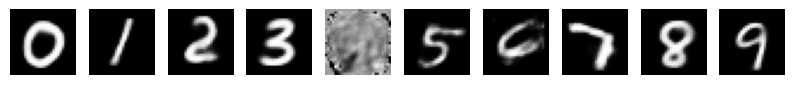

In [16]:
model.eval()
with torch.no_grad():
    # Generate one sample for each digit 0-9
    z = torch.randn(num_classes, latent_dim).to(device)
    labels = torch.arange(num_classes).to(device)
    y = F.one_hot(labels, num_classes).float()
    # y = F.one_hot(torch.full((10,), 4, device=labels.device), num_classes).float()
    samples = model.decode(z, y.to(device)).cpu().view(-1, 1, 28, 28)

    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(1, num_classes, figsize=(10, 1))
    for i, ax in enumerate(axes):
        ax.imshow(samples[i, 0], cmap="gray")
        ax.axis("off")
    plt.show()